# (Incorporated into the workflow)

# Importing packages

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

A convenient function for plotting ccdfs. 

In [2]:
def plot_col_ccdf(df, col):
    N = len(df)
    Y = np.linspace(1.0/N, 1.0, N)
    X = df[col].sort_values(ascending=False)
    plt.figure(figsize=(4,3)); plt.xlabel("Number of addresses"); plt.ylabel("CCDF")
    _ = plt.loglog(X,Y)

# Data loading, merging, and cleaning

In [3]:
dtypes = {'id_Art': 'int',
          'Year': 'int',
          'Main_country': 'category',
          'nb_AUTEUR': 'int',
          'NB_ADRESSE': 'int',
          'nb_REFERENCE': 'int', 
          'FI_2': 'float', 
          'CIT_ALL_IAC': 'int', 
          'GENDER_TOPIC': 'category', 
          'gender_First': 'category',
          'gender_Last': 'category',
          'fracF': 'float',
          'FractM': 'float',
          'Ediscipline': 'category',
          'ESpecialite': 'category'}
rawdf = pd.read_csv('../data/genderXgender_v20180710.txt', sep='\t', dtype=dtypes)
rawdf.head(2)

,id_Art,Year,Main_country,nb_AUTEUR,NB_ADRESSE,nb_REFERENCE,rEVUE,FI_2,CIT_ALL_IAC,GENDER_TOPIC,gender_First,gender_Last,fractF,FractM,Ediscipline,ESpecialite
0,29496682,2008,Canada,1,1,10,ADVANCES IN EXPERIMENTAL MEDICINE AND BIOLOGY,1.059,1,N,M,M,nan,1.000,Biomedical Research,Biochemistry & Molecular Biology
1,29496694,2008,United States,5,1,14,ADVANCES IN EXPERIMENTAL MEDICINE AND BIOLOGY,1.059,5,N,M,M,0.200,0.800,Biomedical Research,Biochemistry & Molecular Biology


In [4]:
rawdf.dtypes

id_Art             int64
Year               int64
Main_country    category
nb_AUTEUR          int64
NB_ADRESSE         int64
nb_REFERENCE       int64
rEVUE             object
FI_2             float64
CIT_ALL_IAC        int64
GENDER_TOPIC    category
gender_First    category
gender_Last     category
fractF           float64
FractM           float64
Ediscipline     category
ESpecialite     category
dtype: object

In [5]:
len(rawdf)

3298951

## Renaming columns

These are the fields in the dataset. 

- `id_Art`: paper unique id
- `Year`: paper publication year
- `Main_country`: main country of paper
- `nb_auteur`: number of authors of paper
- `nb_adresses`: number of institutional addresses on paper
- `nb_reference`: number of cited references in the paper
- `Revue`: journal
- `FI_2`: two year IF of the journal
- `CIT_ALL_IAC`: all citations received by paper
- `GENDER_TOPIC`: gender content of the paper. N = None, B=Both genders, M=Male, F=Female
- `gender_First`: gender of first author
- `gender_Last`: gender of last author
- `fractF`: fraction of female authors
- `FractM`: fraction of male authors
- `EDiscipline`: broad discipline of paper
- `Especialite`: speaciality of the paper

Let's rename them in a more consistent and informative manner. 

In [6]:
rename_dic = {'id_Art': 'PID',
              'Year': 'YEAR',
              'Main_country': 'MAIN_COUNTRY',
              'nb_AUTEUR': 'N_AUTHORS',
              'NB_ADRESSE': 'N_ADDRESSES',
              'nb_REFERENCE': 'N_REFS',
              'rEVUE': 'VENUE', 
              'FI_2': 'IF', 
              'CIT_ALL_IAC': 'N_CITATIONS',
              'gender_First': 'GENDER_FIRST', 
              'gender_Last': 'GENDER_LAST', 
              'fractF': 'FEMALE_FRACTION', 
              'FractM': 'MALE_FRACTION',
              'Ediscipline': 'DISCIPLINE',
              'ESpecialite': 'SUBDISCIPLINE'}
rawdf.rename(index=str, columns=rename_dic, inplace=True)
rawdf.head(2)

,PID,YEAR,MAIN_COUNTRY,N_AUTHORS,N_ADDRESSES,N_REFS,VENUE,IF,N_CITATIONS,GENDER_TOPIC,GENDER_FIRST,GENDER_LAST,FEMALE_FRACTION,MALE_FRACTION,DISCIPLINE,SUBDISCIPLINE
0,29496682,2008,Canada,1,1,10,ADVANCES IN EXPERIMENTAL MEDICINE AND BIOLOGY,1.059,1,N,M,M,nan,1.000,Biomedical Research,Biochemistry & Molecular Biology
1,29496694,2008,United States,5,1,14,ADVANCES IN EXPERIMENTAL MEDICINE AND BIOLOGY,1.059,5,N,M,M,0.200,0.800,Biomedical Research,Biochemistry & Molecular Biology


## Merging with continent data

In [7]:
cont_file = '../data/country_continent.csv'
cont_supp_file = cont_file.replace('country_continent', 'country_continent_added')

In [8]:
raw_cont_df = pd.read_csv(cont_file) 
raw_cont_df.head(2)

,COUNTRY,CONTINENT
0,United Arab Republic,Asia
1,Burundi,Africa


In [9]:
raw_cont_df.CONTINENT.value_counts()

Africa              65
Asia                59
Europe              52
South America       38
Oceania             23
Northern America     4
Unknown              2
Name: CONTINENT, dtype: int64

Let's first check the country names. 

In [10]:
set(rawdf.MAIN_COUNTRY) - set(raw_cont_df.COUNTRY)

{'Bangladesh',
 'Burkina Faso',
 'Democratic Republic of the Congo',
 'Netherlands-Antilles',
 'Republic of Serbia',
 'Saint-Vincent-et-les-Grenadines',
 'South Sudan',
 'Trinidad and Tobago'}

Most of them are not matched due to some variations in the spelling. Let's take a simple approach of appending the continent assignments for them. We store them in a new file and load them here. 

In [11]:
temp_df = pd.read_csv(cont_supp_file) 
temp_df

,COUNTRY,CONTINENT
0,Bangladesh,Asia
1,Burkina Faso,Africa
2,Democratic Republic of the Congo,Africa
3,Netherlands-Antilles,South America
4,Republic of Serbia,Europe
5,Saint-Vincent-et-les-Grenadines,South America
6,South Sudan,Africa
7,Trinidad and Tobago,South America


In [12]:
cont_df = pd.concat([raw_cont_df, temp_df])
set(rawdf.MAIN_COUNTRY) - set(cont_df.COUNTRY)

set()

In [13]:
df = pd.merge(rawdf, cont_df, left_on='MAIN_COUNTRY', right_on='COUNTRY', how='left')
assert len(df) == len(rawdf)

In [14]:
df[df.CONTINENT.isnull()].MAIN_COUNTRY.value_counts()

Series([], Name: MAIN_COUNTRY, dtype: int64)

In [15]:
len(df)

3298951

In [16]:
df.sample(3)

,PID,YEAR,MAIN_COUNTRY,N_AUTHORS,N_ADDRESSES,N_REFS,VENUE,IF,N_CITATIONS,GENDER_TOPIC,GENDER_FIRST,GENDER_LAST,FEMALE_FRACTION,MALE_FRACTION,DISCIPLINE,SUBDISCIPLINE,COUNTRY,CONTINENT
3052206,50549583,2013,Spain,8,3,48,MOLECULAR & CELLULAR PROTEOMICS,1.920,6,N,F,F,0.375,0.625,Biomedical Research,Biochemistry & Molecular Biology,Spain,Europe
1718091,52113966,2013,China,7,2,9,GENETICS AND MOLECULAR RESEARCH,0.819,1,N,INI,INI,nan,nan,Biomedical Research,Genetics & Heredity,China,Asia
939523,47537229,2011,Turkey,3,1,25,REPRODUCTION IN DOMESTIC ANIMALS,0.992,2,M,INI,INI,nan,nan,Clinical Medicine,Veterinary Medicine,Turkey,Europe


In [17]:
df.CONTINENT.value_counts()

Northern America    1122655
Europe              1101293
Asia                 830092
South America        107660
Oceania              102907
Africa                34344
Name: CONTINENT, dtype: int64

## Checking YEAR column

In [18]:
df.YEAR.value_counts()

2015    419530
2014    415277
2013    408843
2012    392369
2011    367219
2010    351996
2009    334431
2008    323201
2016    286085
Name: YEAR, dtype: int64

Looks alright. 

## Checking the gender columns

In [19]:
df.GENDER_FIRST.value_counts()

M      1364289
F       958865
INI     390723
UNK     311235
UNI      69387
m        33315
f        30842
uni       3194
unk         82
Name: GENDER_FIRST, dtype: int64

In [20]:
df.GENDER_LAST.value_counts()

M      1762213
F       668304
INI     407760
UNK     276190
UNI      79968
m        49263
f        28640
uni       2438
unk        122
Name: GENDER_LAST, dtype: int64

In [21]:
df.GENDER_TOPIC.value_counts()

N    1428777
B    1119664
F     385786
M     364724
Name: GENDER_TOPIC, dtype: int64

In [22]:
df.GENDER_TOPIC.isnull().sum()

0

Let's replace 'INI', 'UNK', 'UNI', 'uni', 'unk' with `np.nan`, and make `m` and `f` to uppercase. 

In [23]:
gender_replace_dic = {'INI': np.nan, 'UNK': np.nan, 'UNI': np.nan, 
                      'uni': np.nan, 'unk': np.nan, 'm': 'M', 'f': 'F'}
df.replace({'GENDER_FIRST': gender_replace_dic,
            'GENDER_LAST': gender_replace_dic}, inplace=True)
df.GENDER_FIRST.value_counts()

M    1397604
F     989707
Name: GENDER_FIRST, dtype: int64

In [24]:
len(df[ (df.GENDER_FIRST.isnull()) | (df.GENDER_LAST.isnull()) ])

1192430

Let's drop these rows with unknown gender. 

In [25]:
df.dropna(subset=['GENDER_FIRST', 'GENDER_LAST', 'GENDER_TOPIC'], inplace=True)
len(df)

2106521

Is the first author's gender and the last author's gender same when there is only one author?

In [26]:
all(df[df.N_AUTHORS == 1].GENDER_FIRST == df[df.N_AUTHORS == 1].GENDER_LAST)

True

## Disciplines

In [27]:
df.DISCIPLINE.isnull().sum()

0

In [28]:
df.SUBDISCIPLINE.isnull().sum()

0

In [29]:
df.DISCIPLINE.value_counts()

Clinical Medicine      1373352
Biomedical Research     607959
Health                  125210
Name: DISCIPLINE, dtype: int64

In [30]:
df.SUBDISCIPLINE.value_counts()

Biochemistry & Molecular Biology           169450
Neurology & Neurosurgery                   153726
General Biomedical Research                143210
Pharmacology                               123995
General & Internal Medicine                119197
Cancer                                     110305
Surgery                                     89951
Cardiovascular System                       79515
Immunology                                  73011
Microbiology                                53504
Radiology & Nuclear Medicine                53389
Genetics & Heredity                         51249
Cellular Biology Cytology & Histology       44619
Public Health                               42284
Endocrinology                               40020
Gastroenterology                            38936
Psychiatry                                  38890
Orthopedics                                 35386
Biomedical Engineering                      34354
Pediatrics                                  32474


## Citations

In [31]:
df.N_CITATIONS.isnull().sum()

0

In [32]:
df.N_CITATIONS.describe()

count   2106521.000
mean         14.459
std          39.882
min           0.000
25%           2.000
50%           6.000
75%          15.000
max       22928.000
Name: N_CITATIONS, dtype: float64

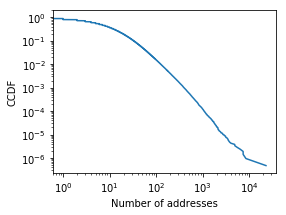

In [33]:
plot_col_ccdf(df, 'N_CITATIONS')

## Impact factor

In [34]:
df.IF.isnull().sum()

55285

In [35]:
df.dropna(subset=['IF'], inplace=True)

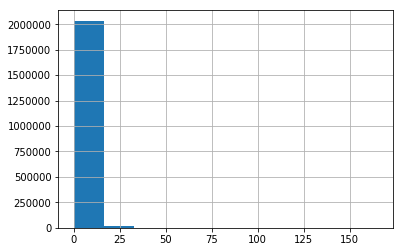

In [36]:
df.IF.hist()

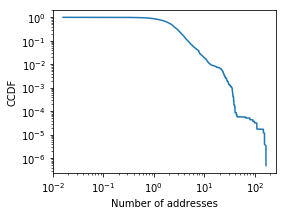

In [37]:
plot_col_ccdf(df, 'IF')

## N_REFS

In [38]:
df.N_REFS.isnull().sum()

0

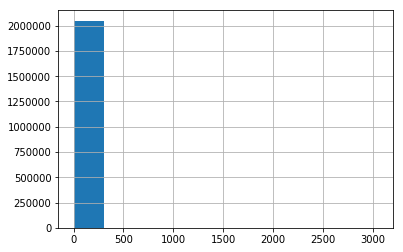

In [39]:
df.N_REFS.hist()

In [40]:
df.N_REFS.describe()

count   2051236.000
mean         41.378
std          32.391
min           0.000
25%          24.000
50%          35.000
75%          49.000
max        3048.000
Name: N_REFS, dtype: float64

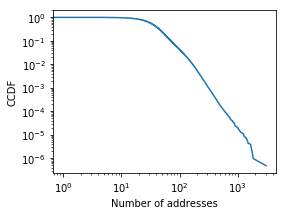

In [41]:
plot_col_ccdf(df, 'N_REFS')

## N_ADDRESSES

In [42]:
df.N_ADDRESSES.isnull().sum()

0

In [43]:
df.N_ADDRESSES.describe()

count   2051236.000
mean          2.890
std           2.106
min           1.000
25%           1.000
50%           2.000
75%           4.000
max         121.000
Name: N_ADDRESSES, dtype: float64

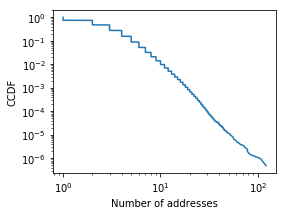

In [44]:
plot_col_ccdf(df, 'N_ADDRESSES')

## Checking the N_AUTHORS column

In [45]:
df.N_AUTHORS.describe()

count   2051236.000
mean          5.570
std           3.442
min           1.000
25%           3.000
50%           5.000
75%           7.000
max        1014.000
Name: N_AUTHORS, dtype: float64

In [46]:
df.N_AUTHORS.isnull().sum()

0

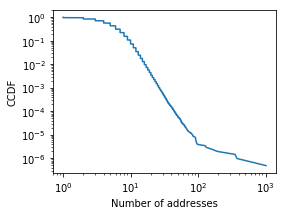

In [47]:
plot_col_ccdf(df, 'N_AUTHORS')

Quite similar to the number of addresses (naturally). 

In [48]:
len(df[df.N_AUTHORS == 1])

84090

In [49]:
len(df[df.N_AUTHORS != 1])

1967146

In [50]:
len(df[df.N_AUTHORS > 1]) + len(df[df.N_AUTHORS == 1]) == len(df)

True

Let's save them into two different tables. 

In [51]:
sdf = df[df.N_AUTHORS == 1]
sdf.to_csv('single_author.csv', index=False)

mdf = df[df.N_AUTHORS > 1]
mdf.to_csv('multi_author.csv', index=False)